In [2]:
import sys
molgen_path = "../"
if molgen_path not in sys.path:
    sys.path.insert(0, molgen_path)

In [23]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem import AllChem
from utils import MonomersLib, HELMConverter, draw_mol, get_main_mol, remove_isotopes, is_same_mol

lib = MonomersLib()
monomers_lib_path = molgen_path + "data/helm/library/chembl_35_monomer_library.xml"
lib.load_xml(monomers_lib_path)
monomers_lib_path = molgen_path + "data/helm/library/modan.json"
lib.load_json(monomers_lib_path)
converter = HELMConverter(lib)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[01:19:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:19:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[01:19:39] WARNING: not removing hydrogen atom with dummy atom neighbors


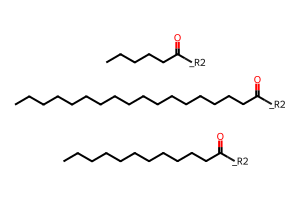

In [ ]:
# helm = "PEPTIDE1{[S5Left]}|PEPTIDE1{[S5Right]}|PEPTIDE1{[R8]}|}$$$$"
# helm = "PEPTIDE1{[Aib]}|PEPTIDE1{[Dab]}|PEPTIDE1{[Orn]}|}$$$$"
# helm = "PEPTIDE1{[Ac5c]}|PEPTIDE1{[Ac6c]}}$$$$"
helm = "PEPTIDE1{[Pentanoyl]}|PEPTIDE1{[Dodecanoyl]}|PEPTIDE1{[Octadecanoyl]}}$$$$"
mol = converter._convert(helm, close=False)
draw_mol(mol, 300, 200)

In [16]:
width, height = 600, 300
helm, smiles = "PEPTIDE1{K.L.L.K.K.A.G.K.L.L.K.K.[R8].G.K.L.L.K.K.[S5Right].G.[am]}$PEPTIDE1,PEPTIDE1,13:R3-20:R3$$$", "NC(CNC([C@@](CCC/C=C\CCCCCC1)(C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC([C@]1(C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)NC(CNC([C@H](C)NC([C@H](CCCCN)NC([C@H](CCCCN)NC([C@H](CC(C)C)NC([C@H](CC(C)C)NC([C@H](CCCCN)N)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O"
#H-KLLKKAGKLLKKR8GKLLKKS5G-NH2
mol_h = converter.convert(helm)
mol_s = Chem.MolFromSmiles(smiles)
print(is_same_mol(mol_h, mol_s))
#draw_mol(mol_h, width=width, height=height)
#draw_mol(mol_s, width=width, height=height)
print(Chem.MolToSmiles(mol_h))
print(Chem.MolToSmiles(mol_s))

True
CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@]1(C)CCCCCC/C=C\CCC[C@@](C)(C(=O)NCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)CNC1=O
CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)CNC(=O)[C@H](C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@]1(C)CCCCCC/C=C\CCC[C@@](C)(C(=O)NCC(N)=O)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)CNC1=O


In [ ]:
import re

def split_modan_pep_seq(seq: str) -> list[str]:
    pattern = (
        r"-"
        r"\[[^\[\]]*(?:\[[^\[\]]*\][^\[\]]*)*\]"
        r"|PEPTIDE\d+"
        r"|RNA\d+"
        r"|CHEM\d+"
        r"|BLOB\d+"
        r"|R\d"
        r"|pair"
        #r"|V2.0"
        r"|[A-Z]"
        r"|[a-z]"
        r"|\||\(|\)|\{|\}|-|\$|:|,|\."
        r"|\d{2}|\d"
        r")"
    )
    tokens = re.findall(pattern, helm)

def helm_from_modan_pep_seq(seq: str) -> str:
    pass

In [16]:
import pandas as pd

modan_raw_path = molgen_path + "data/misc/Dataset_MODAN_initial.xlsx"
df = pd.read_excel(modan_raw_path, sheet_name="Sheet1", index_col=0)

for idx, r in df.iterrows():
    pep = r["Peptide sequence"]
    smiles = r["SMILES"]
    print(pep, smiles)

H-KKKKKKKKKGGGLLALLALLA-NH2 [H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(NCC(NCC(NCC(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N)=O)C)=O)=O)=O)C)=O)=O)=O)C)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O
H-GIGKFLHSAKKFGKAFVGEIMNS-NH2 [H]NCC(N[C@]([C@@H](C)CC)([H])C(NCC(N[C@@H](CCCCN)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CO)C(N[C@H](C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@H](C(NCC(N[C@@H](CCCCN)C(N[C@H](C(N[C@H](C(N[C@@H](C(C)C)C(NCC(N[C@@H](CCC(O)=O)C(N[C@]([C@@H](C)CC)([H])C(N[C@H](C(N[C@@H](CC(N)=O)C(N[C@@H](CO)C(N)=O)=O)=O)CCSC)=O)=O)=O)=O)=O)CC1=CC=CC=C1)=O)C)=O)=O)=O)CC2=CC=CC=C2)=O)=O)=O)C)=O)=O)CC3=CN=CN3)=O)=O)CC4=CC=CC=C4)=O)=O)=O)=O
H-gIgKfLhSaKkFgKaFv-NH2 [H]NCC(N[C@]([H])(C(NCC(N[C@H](C(N[C@H](CC1=CC=CC=C1)C(N[C@H](C(N[C@H](CC2=CN=CN2)C(N[C@H](C(N[C@H](C)C(N[C@H](C(N[C@@H](C(N[C@@H](CC3=CC